In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

In [2]:
# data = pd.read_csv('Data/DatalogWithoutGraph.csv', index_col = "sample")

In [37]:
filenames = [i for i in os.listdir('Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/') if i.endswith(".dat")]

file_lengths = []

for i in range(len(filenames)):

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t", index_col = "sample")

    file_lengths.append(len(data))

file_lengths = np.array(file_lengths)

n_samples_start = 0 #300 is all we need for the motion phase to complete
n_samples_end = 2400

# fix, axs = plt.subplots(3, 2, figsize=(15, 15))

encoder_values = []
endpoint_values = []
endpoint_position_values = []
for i in np.where(file_lengths > n_samples_end)[0]:

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t", index_col = "sample")

    # axs[0, 0].plot(data["ENC_POS_FLOATMAG_BH"].iloc[n_samples_start:n_samples_end] / 200)

    encoder_values.append((data["ENC_POS_FLOATMAG_BH"].iloc[n_samples_start:n_samples_end] / 200).values)

    # axs[1, 0].plot(data["FLOATMAG_ACC_ADC_PORT_0"].iloc[n_samples_start:n_samples_end])

    endpoint_values.append(data["FLOATMAG_ACC_ADC_PORT_0"].iloc[n_samples_start:n_samples_end].values)

    functional_point_velocity = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
    functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values * 269.4 #multiplying by 269.4 to convert to um (on the assumption that max position is 500 um)

    # axs[2,0].plot(functional_point_position[n_samples_start:n_samples_end])
    endpoint_position_values.append(functional_point_position[n_samples_start:n_samples_end])


encoder_values = np.array(encoder_values)
endpoint_values = np.array(endpoint_values)
endpoint_position_values = np.array(endpoint_position_values)

mean_encoder_values = np.mean(encoder_values, axis=0)
mean_endpoint_values = np.mean(endpoint_values, axis=0)
mean_endpoint_position_values = np.mean(endpoint_position_values, axis=0)



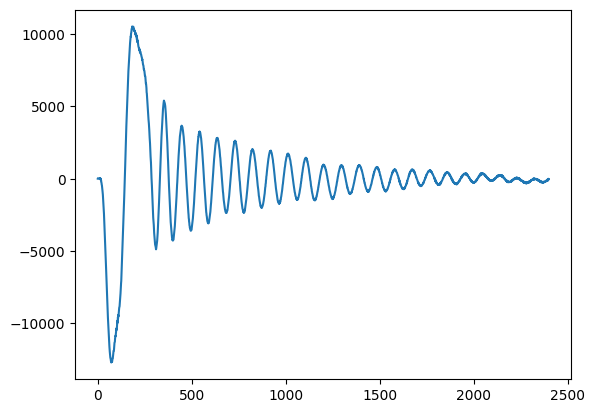

In [43]:
plt.plot(mean_endpoint_values)


In [7]:
# relevant_data = data[['Time (s)', 'CMD_POS_FLOATMAG_BH', 'ENC_POS_FLOATMAG_BH', 'POS_ERR_FLOATMAG_BH', 'DAC_FLOATMAG_BH', 'ENC_POS_FLOATMAG_FBX', 'ENC_POS_FLOATMAG_FBY', 'EndPoint_X(um)', 'ENC_X(um)']].iloc[839:]

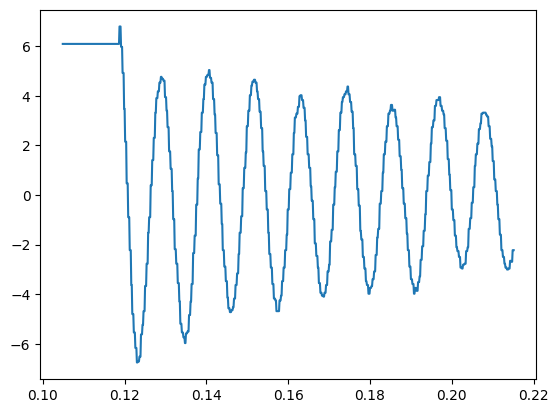

In [38]:
# plt.plot(relevant_data['Time (s)'].values, relevant_data['EndPoint_X(um)'].values, label = 'EndPoint_X(um)')

In [16]:
#Time has fixed interval of 0.000125 seconds, (sampling rate of 8000 hz)

8000.0

In [51]:
# fourier = np.fft.fft(relevant_data['EndPoint_X(um)'].values)
fourier = np.fft.fft(mean_endpoint_values[300:])
# fourier = np.fft.fft(mean_endpoint_position_values)

magnitude = np.abs(fourier)

timestep = 1/8000

freq = np.fft.fftfreq(len(fourier), d = timestep)

pos_freq = freq[freq > 0]

pos_magnitude = magnitude[freq > 0]

# Doubling the magnitudes, excluding the DC component
pos_magnitude[1:] = pos_magnitude[1:] * 2

#should not double nyquist frequency if number of samples is even
if len(pos_magnitude) % 2 == 0:
    pos_magnitude[-1] = pos_magnitude[-1] / 2

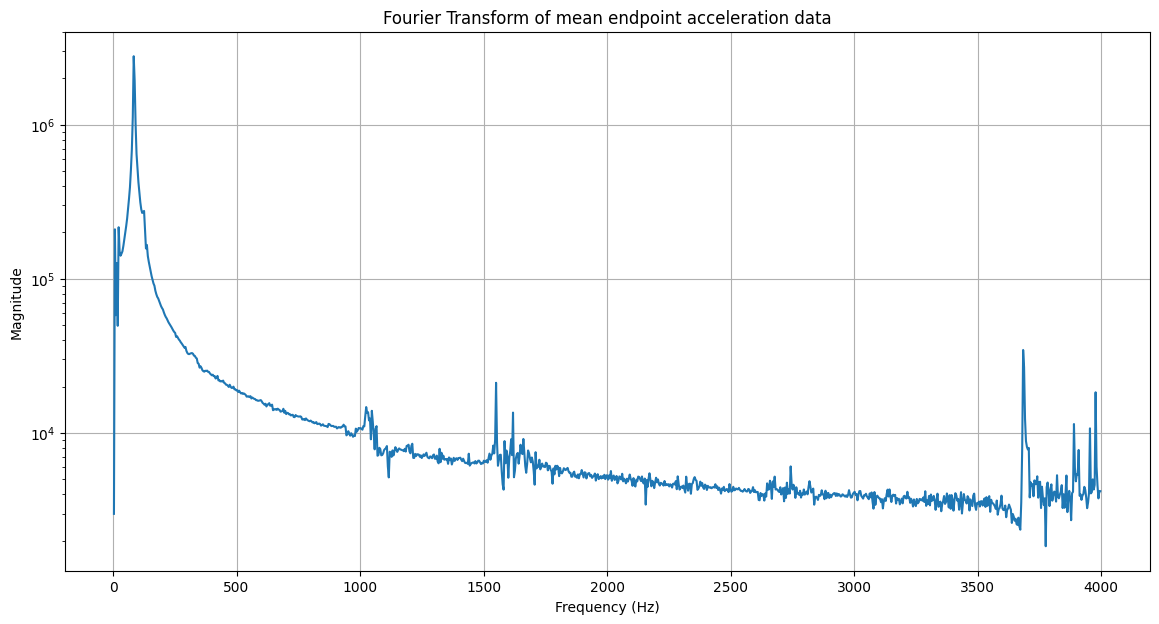

In [52]:
# plt.plot(pos_freq, pos_magnitude)
plt.figure(figsize=(14, 7))
plt.plot(pos_freq, pos_magnitude)
# plt.title('Fourier Transform of EndPoint_X(um) (Segmented Data)')
plt.title('Fourier Transform of mean endpoint acceleration data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.yscale('log')  # Using a logarithmic scale for better visibility
plt.grid(True)
plt.show()

In [49]:
# #vibrations actually happen from ~0.119 seconds onwards
# np.where(relevant_data['Time (s)'] >= 0.119)[0][0]

113

In [50]:
# relevant_data = relevant_data.iloc[113:]

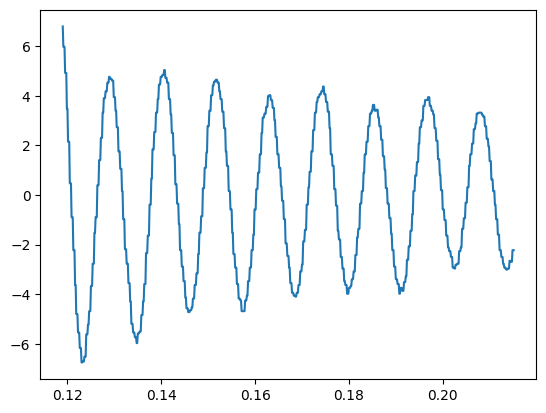

In [51]:
# #Ok maybe we should actually start after the vibrations have started

# #this happens at around 0.119 seconds onwards

# plt.plot(relevant_data['Time (s)'].values, relevant_data['EndPoint_X(um)'].values, label = 'EndPoint_X(um)')

In [52]:
# fourier = np.fft.fft(relevant_data['EndPoint_X(um)'].values)

# magnitude = np.abs(fourier)

# timestep = 0.000125

# freq = np.fft.fftfreq(len(fourier), d = timestep)

# pos_freq = freq[freq > 0]

# pos_magnitude = magnitude[freq > 0]

# # Doubling the magnitudes, excluding the DC component
# pos_magnitude[1:] = pos_magnitude[1:] * 2

# #should not double nyquist frequency if number of samples is even
# if len(pos_magnitude) % 2 == 0:
#     pos_magnitude[-1] = pos_magnitude[-1] / 2

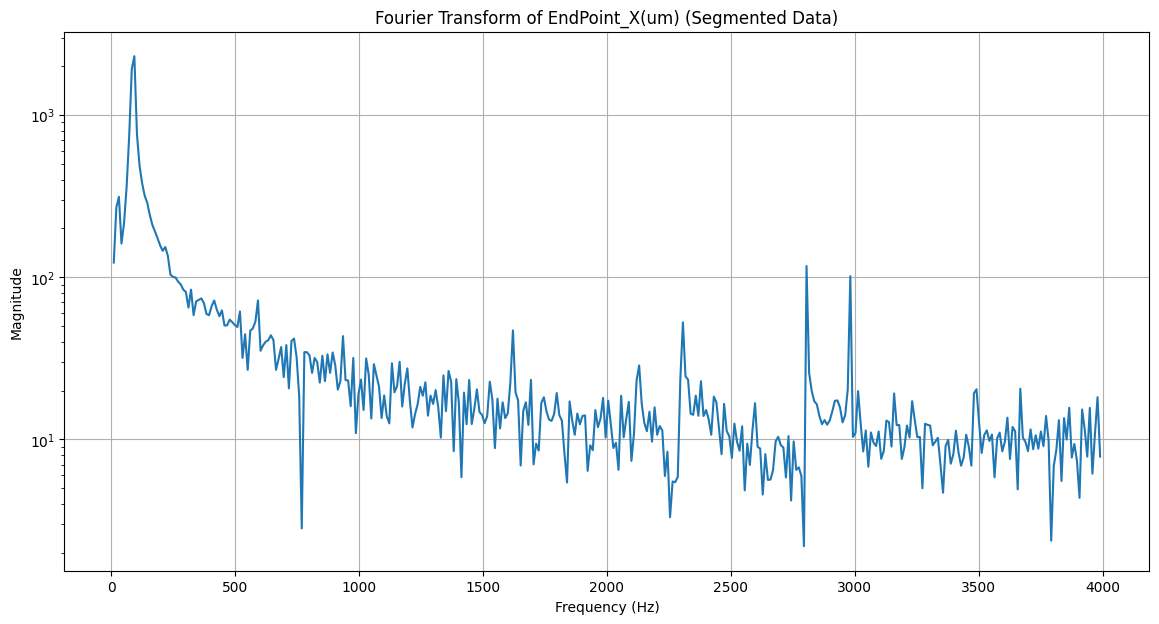

In [53]:
# # plt.plot(pos_freq, pos_magnitude)
# plt.figure(figsize=(14, 7))
# plt.plot(pos_freq, pos_magnitude)
# plt.title('Fourier Transform of EndPoint_X(um) (Segmented Data)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude')
# plt.yscale('log')  # Using a logarithmic scale for better visibility
# plt.grid(True)
# plt.show()

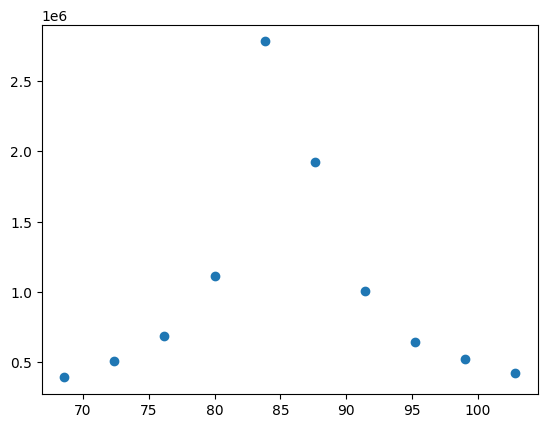

In [55]:
#lets get the dominant frequencies from this data and the corresponding magnitude

indx = np.argsort(pos_magnitude)[::-1][:10]

dominant_freq = pos_freq[indx]
dominant_magnitude = pos_magnitude[indx]

plt.scatter(dominant_freq, dominant_magnitude)



In [54]:
dominant_freq, dominant_magnitude

(array([ 83.80952381,  87.61904762,  80.        ,  91.42857143,
         76.19047619,  95.23809524,  99.04761905,  72.38095238,
        102.85714286,  68.57142857]),
 array([2778712.69649299, 1924824.73187739, 1115145.25766018,
        1004015.07286545,  686846.04017177,  644318.16027186,
         521123.97758332,  506078.23964327,  423119.83357005,
         392532.90396627]))

In [63]:
#what was the dc freqency?

pos_freq[0]

10.38961038961039

In [64]:
#ok so we have the dominant frequency, 93.5 Hz

#lets plot this now

1/0.01

100.0

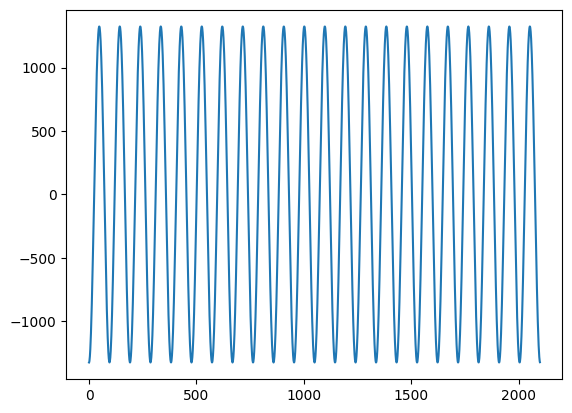

In [56]:
#ok we gonna just isolate the highest frequency, and then inverse fft
og_data = mean_endpoint_values[300:]

fourier = np.fft.fft(og_data)
# fourier = np.fft.fft(relevant_data['EndPoint_X(um)'].values)


magnitude = np.abs(fourier)

indxs = np.argsort(magnitude)[::-1][:2] #poth positive and negative index

isolated = np.zeros(len(fourier), dtype = complex)

isolated[indxs] = fourier[indxs]

# plt.plot(relevant_data["Time (s)"].values, np.fft.ifft(isolated).real)
plt.plot(np.fft.ifft(isolated).real)


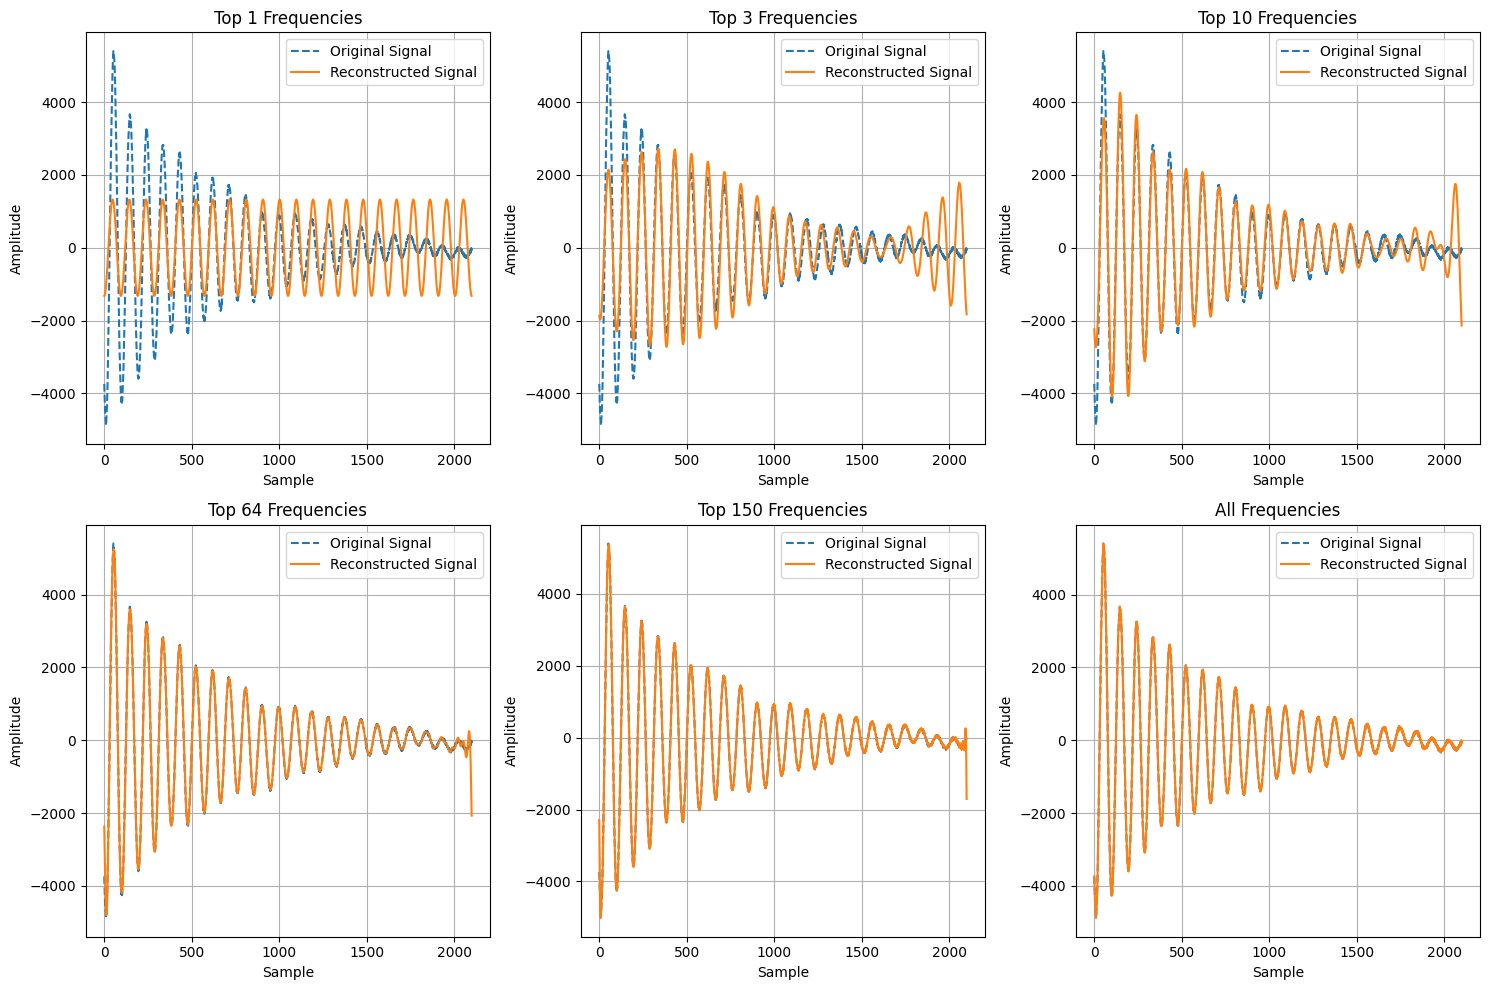

In [50]:
#plotting the original signal and the reconstructed signal based on number of isolated frequencies

n_frequencies_list = [1, 3, 10, 64, 150, 99999] 

# Creating 2x3 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2x3 matrix to a vector for easier indexing


# Looping through the subplots
for i, n_frequency in enumerate(n_frequencies_list):

    n_indices = n_frequency * 2  # Doubling the number of indices to account for negative frequencies
    
    # Isolating the top n_indices frequencies
    indxs = np.argsort(magnitude)[::-1][:n_indices]
    isolated = np.zeros(len(fourier), dtype=complex)
    isolated[indxs] = fourier[indxs]
    
    # Compute IFFT of the isolated frequencies
    reconstructed_signal = np.fft.ifft(isolated).real
    
    # Plotting original and reconstructed signals
    # axs[i].plot(relevant_data["Time (s)"].values, relevant_data['EndPoint_X(um)'].values, label='Original Signal', linestyle='dashed')
    axs[i].plot(og_data, label='Original Signal', linestyle='dashed')

    # axs[i].plot(relevant_data["Time (s)"].values, reconstructed_signal, label='Reconstructed Signal', linestyle='solid')
    axs[i].plot(reconstructed_signal, label='Reconstructed Signal', linestyle='solid')

    axs[i].legend()
    # axs[i].set_xlabel('Time [s]')
    axs[i].set_xlabel('Sample')
    axs[i].set_ylabel('Amplitude')
    if n_frequency == 99999:
        axs[i].set_title('All Frequencies')
    else:
        axs[i].set_title(f'Top {n_frequency} Frequencies')
    axs[i].grid(True)

# Adjusting the layout and showing the plots
plt.tight_layout()
plt.show()

In [ ]:
#what conclusions do we get from this?
#idk lol
#fourier analysis would not be my direction to take this